In [1]:
import numpy as np
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import functions
# 
%load_ext autoreload
%autoreload 2

In [2]:
#using pET
pET = pd.read_pickle('results/pET_complete.pkl.gz', compression='infer')

In [15]:
#Bhaskaran and Ponnuswamy 1988

flexib_bhask = {
'A': 0.3570 ,
'R': 0.5290 ,
'N': 0.4630 ,
'D': 0.5110 ,
'C': 0.3460 ,
'Q': 0.4930 ,
'E': 0.4970 ,
'G': 0.5440 ,
'H': 0.3230 ,
'I': 0.4620 ,
'L': 0.3650 ,
'K': 0.4660 ,
'M': 0.2950 ,
'F': 0.3140 ,
'P': 0.5090 ,
'S': 0.5070 ,
'T': 0.4440 ,
'W': 0.3050 ,
'Y': 0.4200 ,
'V': 0.3860 
} 



#. Local flexibility (Ragone et al. 1989)
flexib_ragone = {
'A' :705.4200,
'R' :1484.2800,
'N' :513.4601, 
'D' :34.9600, 
'C' :2412.5601,
'Q' :1087.8300,
'E' :1158.6600,
'G' :33.1800,
'H' :1637.1300,
'I' :5979.3701,
'L' :4985.7300,
'K' :699.6900,
'M' :4491.6602,
'F' :5203.8599,
'P' :431.9600,
'S' :174.7600,
'T' :601.8800,
'W' :6374.0698,
'Y' :4291.1001,
'V' :4474.4199 
}


# Flexibility
# Normalized flexibility parameters (B-values), average
# Vihinen M., Torkkila E., Riikonen P. Proteins. 19(2):141-9(1994).
flexibilities_vih = {"A": 0.984, "C": 0.906, "E": 1.094, "D": 1.068,
"G": 1.031, "F": 0.915, "I": 0.927, "H": 0.950,
"K": 1.102, "M": 0.952, "L": 0.935, "N": 1.048,
"Q": 1.037, "P": 1.049, "S": 1.046, "R": 1.008,
"T": 0.997, "W": 0.904, "V": 0.931, "Y": 0.929}


#Smith, David K., et al. 2003
flexibilities_smith = {'A': 0.717, 'C': 0.668, 'E': 0.963, 'D': 0.921,\
                         'G': 0.843, 'F': 0.599, 'I': 0.632, 'H': 0.754, \
                         'K': 0.912, 'M': 0.685, 'L': 0.681, 'N': 0.851,\
                         'Q': 0.849, 'P': 0.85, 'S': 0.84, 'R': 0.814, 'T': 0.758, \
                         'W': 0.626, 'V': 0.619, 'Y': 0.615}


In [16]:
pET['Initial weights_bhask'] = pET['Protein'].apply(lambda x:functions.solubility_score(x, flexib_bhask))
pET['Initial weights_ragone'] = pET['Protein'].apply(lambda x:functions.solubility_score(x, flexib_ragone))
pET['Initial weights_vih'] = pET['Protein'].apply(lambda x:functions.solubility_score(x, flexibilities_vih))
pET['Initial weights_smith'] = pET['Protein'].apply(lambda x:functions.solubility_score(x, flexibilities_smith))


pET['Bhaskaran and Ponnuswamy 1988'] = pET['Initial weights_bhask'].apply(np.mean)
pET['Ragone et al. 1989'] = pET['Initial weights_ragone'].apply(np.mean)
pET['Vihinen et al. 1994'] = pET['Initial weights_vih'].apply(np.mean)
pET['Smith et al. 2003'] = pET['Initial weights_smith'].apply(np.mean)



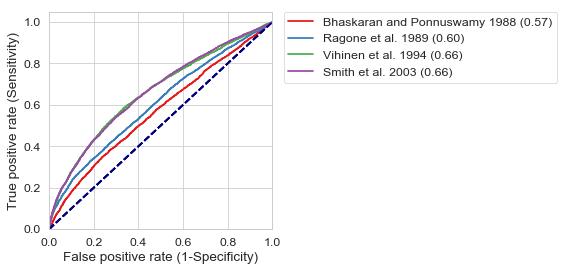

In [17]:
df = pET[['Bhaskaran and Ponnuswamy 1988', 'Ragone et al. 1989', 'Vihinen et al. 1994',\
         'Smith et al. 2003']].copy()

#some columns have auc <0.5, correcting them
df['Ragone et al. 1989'] = -df['Ragone et al. 1989']
#hmm only one column had auc < 0.5

labels = pET['Solubility'].values
functions.make_roc(df, labels, output=True, fname='Weight_comparision.pdf')

In [18]:
for i, col in enumerate(df.columns):
    preds = df[col].values
    fpr, tpr, _ = functions.roc_curve(labels, preds)
    roc_auc = functions.auc(fpr, tpr)
    print(col, ' : ', roc_auc)

Bhaskaran and Ponnuswamy 1988  :  0.5682692811189877
Ragone et al. 1989  :  0.6037735647542425
Vihinen et al. 1994  :  0.6596054947025343
Smith et al. 2003  :  0.6613120920830531


 ##### Smith et al. had higher AUC

# Old

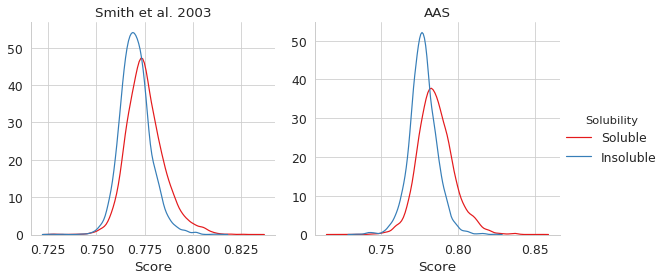

In [8]:
#distibution score for solubility classes


seq_features = pET[['Smith et al. 2003', 'AAS', 'Solubility']].copy()
seq_features['Solubility'] = seq_features['Solubility'].replace(1,'Soluble')
seq_features['Solubility'] = seq_features['Solubility'].replace(0,'Insoluble')
seq_features_plt = seq_features.melt(['Solubility'], var_name='cols',  value_name='vals')


# sns.set(font_scale=2.1)
fg = functions.sns.FacetGrid(seq_features_plt, col='cols', hue='Solubility', 
                       sharex=False, sharey=False, height=4, palette="Set1")
fg.map(functions.sns.kdeplot, 'vals', shade=False, label='Data')\
         .add_legend()\
         .set_titles("{col_name}")\
         .set_axis_labels('Score')

functions.sns.despine()
functions.plt.savefig("figs/Distribution_of_scores_for_optimised_and_initial_weights.pdf")
functions.plt.show()

functions.plt.clf()
functions.plt.close('all')

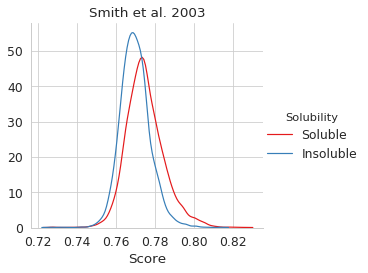

In [13]:
#distibution score for solubility classes


seq_features = pET[['Smith et al. 2003', 'Solubility']].copy()
seq_features['Solubility'] = seq_features['Solubility'].replace(1,'Soluble')
seq_features['Solubility'] = seq_features['Solubility'].replace(0,'Insoluble')
seq_features_plt = seq_features.melt(['Solubility'], var_name='cols',  value_name='vals')


# sns.set(font_scale=2.1)
fg = functions.sns.FacetGrid(seq_features_plt, col='cols', hue='Solubility', 
                       sharex=False, sharey=False, height=4, palette="Set1")
fg.map(functions.sns.kdeplot, 'vals', shade=False, label='Data')\
         .add_legend()\
         .set_titles("{col_name}")\
         .set_axis_labels('Score')

functions.sns.despine()
# functions.plt.savefig("figs/Distribution_of_scores_for_optimised_and_initial_weights.pdf")
functions.plt.show()

functions.plt.clf()
functions.plt.close('all')

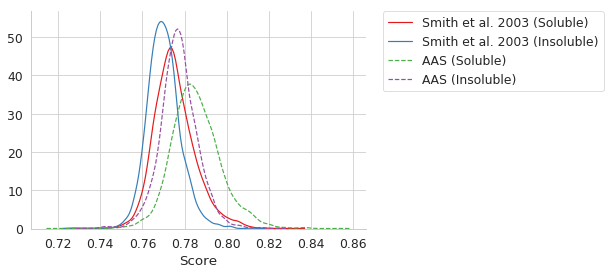

In [11]:
#plot two dist at one place

# seq_features = pET[['Smith et al. 2003', 'Amino acid solubility index', 'Solubility']].copy()
functions.sns.kdeplot(seq_features['Smith et al. 2003'][seq_features['Solubility']=='Soluble'],\
                      legend='Smith et al. 2003 (Soluble)')
functions.sns.kdeplot(seq_features['Smith et al. 2003'][seq_features['Solubility']=='Insoluble'],\
                      legend='Smith et al. 2003 (Insoluble)')

# seq_features = pET[['Smith et al. 2003', 'Amino acid solubility index', 'Solubility']].copy()
functions.sns.kdeplot(seq_features['AAS'][seq_features['Solubility']=='Soluble'],\
                      legend='AAS index (Soluble)', linestyle="--")
functions.sns.kdeplot(seq_features['AAS'][seq_features['Solubility']=='Insoluble'],\
                      legend='AAS index (Insoluble)', linestyle="--")



functions.plt.legend(['Smith et al. 2003 (Soluble)', 'Smith et al. 2003 (Insoluble)', \
                     'AAS (Soluble)', \
                      'AAS (Insoluble)'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
functions.plt.xlabel('Score')



functions.sns.despine()
functions.plt.savefig("figs/Distribution_of_scores_for_optimised_and_initial_weights_in_same_fig.pdf")
functions.plt.show()

functions.plt.clf()
functions.plt.close('all')

In [8]:
#For ecoli data
ecoli_w3110 = pd.read_pickle('results/ecoli.pkl.gz', compression='infer')

ecoli_w3110['Initial weights_bhask'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, flexib_bhask))
ecoli_w3110['Initial weights_ragone'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, flexib_ragone))
ecoli_w3110['Initial weights_vih'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, flexibilities_vih))
ecoli_w3110['Initial weights_smith'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, flexibilities_smith))


ecoli_w3110['Optimised weights'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, aas))

ecoli_w3110['Bhaskaran and Ponnuswamy 1988'] = ecoli_w3110['Initial weights_bhask'].apply(np.mean)
ecoli_w3110['Ragone et al. 1989'] = ecoli_w3110['Initial weights_ragone'].apply(np.mean)
ecoli_w3110['Vihinen et al. 1994'] = ecoli_w3110['Initial weights_vih'].apply(np.mean)
ecoli_w3110['Smith et al. 2003'] = ecoli_w3110['Initial weights_smith'].apply(np.mean)
ecoli_w3110['Amino acid solubility index'] = ecoli_w3110['Optimised weights'].apply(np.mean)


In [9]:
from scipy.stats import spearmanr

d = ecoli_w3110[['Bhaskaran and Ponnuswamy 1988', 'Ragone et al. 1989', 'Vihinen et al. 1994',\
         'Smith et al. 2003', 'Amino acid solubility index', 'Solubility(%)' ]].copy()

df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in d.columns:
    for y in d.columns:
        corr1 = spearmanr(d[x], d[y])
        df_corr.loc[x,y] = corr1[0]
        df_p.loc[x,y] = corr1[1]

df_corr.round(2)


,Bhaskaran and Ponnuswamy 1988,Ragone et al. 1989,Vihinen et al. 1994,Smith et al. 2003,Amino acid solubility index,Solubility(%)
Bhaskaran and Ponnuswamy 1988,1.00,-0.48,0.69,0.68,0.44,0.21
Ragone et al. 1989,-0.48,1.00,-0.67,-0.60,-0.62,-0.27
Vihinen et al. 1994,0.69,-0.67,1.00,0.94,0.81,0.41
Smith et al. 2003,0.68,-0.60,0.94,1.00,0.78,0.39
Amino acid solubility index,0.44,-0.62,0.81,0.78,1.00,0.48
Solubility(%),0.21,-0.27,0.41,0.39,0.48,1.00


In [11]:
df_p

,Bhaskaran and Ponnuswamy 1988,Ragone et al. 1989,Vihinen et al. 1994,Smith et al. 2003,Amino acid solubility index,Solubility(%)
Bhaskaran and Ponnuswamy 1988,0.000000e+00,7.983933e-183,0.000000e+00,0.000000e+00,4.113901e-148,6.392742e-33
Ragone et al. 1989,7.983933e-183,0.000000e+00,0.000000e+00,3.173003e-312,0.000000e+00,2.391395e-55
Vihinen et al. 1994,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.033434e-131
Smith et al. 2003,0.000000e+00,3.173003e-312,0.000000e+00,0.000000e+00,0.000000e+00,2.428042e-115
Amino acid solubility index,4.113901e-148,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.345200e-181
Solubility(%),6.392742e-33,2.391395e-55,4.033434e-131,2.428042e-115,2.345200e-181,0.000000e+00


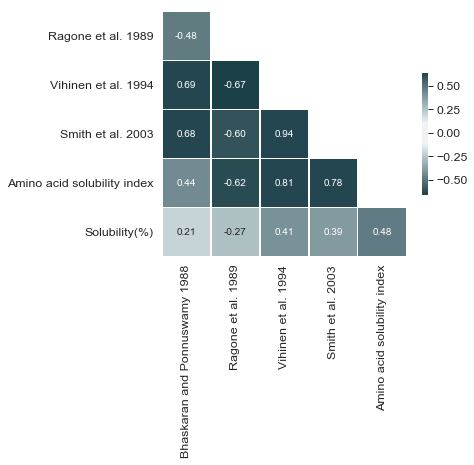

In [12]:
# d = d.rename(columns={'Mol_wt':'Molecular weight', 'Instability_index':'Instability Index', 'Isoelectric_point':'Isoelectric point',\
#                       'Average_flexibility':'Average Flexibility', 'sec_str_Helix':'Secondary structure (Helix)', \
#                      'sec_str_Turn':'Secondary structure (Turn)', 'sec_str_Sheet':'Secondary structure (Sheet)'})

functions.corr_heatmap(d, squared=False, output=False, \
                       fname='Heatmap_for_weights_correlation_with_solubility.pdf', xlim=(0,5), \
                      ylim=(6,1), cmap = functions.sns.diverging_palette(210, 220, sep=40, l=25, as_cmap=True))


In [ ]:
# ax = functions.sns.kdeplot(seq_features['Smith et al. 2003'][seq_features['Solubility']=='Soluble'],\
#             seq_features['Amino acid solubility index'][seq_features['Solubility']=='Soluble'],\
#                            cmap="Reds")

# ax = functions.sns.kdeplot(seq_features['Smith et al. 2003'][seq_features['Solubility']=='Insoluble'],\
#             seq_features['Amino acid solubility index'][seq_features['Solubility']=='Insoluble'],\
#                       cmap="Blues")